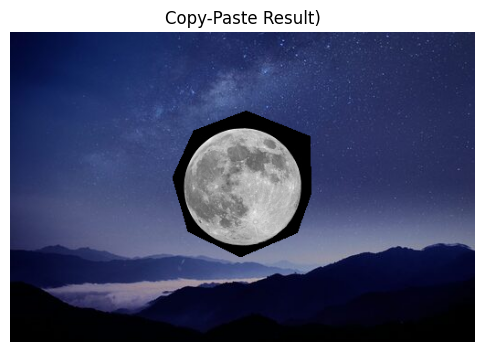

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load images
# --------------------------
bg = cv2.imread("/content/sample_data/imskynight.jpeg")
src = cv2.imread("/content/sample_data/img2.jpg")
mask = cv2.imread("/content/sample_data/mask1.jpg", 0)

bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

# Resize to same size
h, w = bg.shape[:2]
src = cv2.resize(src, (w, h))
mask = cv2.resize(mask, (w, h))

mask_bin = (mask > 127).astype(np.uint8)

# --------------------------
# Copy-paste result (NO Poisson)
# --------------------------
blended_copy = bg.copy()
blended_copy[mask_bin == 1] = src[mask_bin == 1]

# --------------------------
# Plot result
# --------------------------
plt.figure(figsize=(6, 5))
plt.imshow(blended_copy)
plt.title("Copy-Paste Result)")
plt.axis("off")
plt.show()


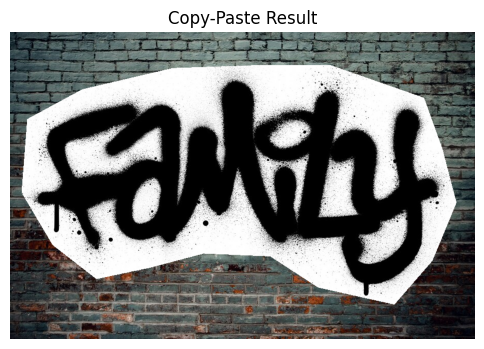

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load images
# --------------------------
bg = cv2.imread("/content/sample_data/wall.jpg")
src = cv2.imread("/content/sample_data/img4.jpg")
mask = cv2.imread("/content/sample_data/mask2.jpg", 0)

bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

# Resize to same size
h, w = bg.shape[:2]
src = cv2.resize(src, (w, h))
mask = cv2.resize(mask, (w, h))

mask_bin = (mask > 127).astype(np.uint8)

# --------------------------
# Copy-paste result (NO Poisson)
# --------------------------
blended_copy = bg.copy()
blended_copy[mask_bin == 1] = src[mask_bin == 1]

# --------------------------
# Plot result
# --------------------------
plt.figure(figsize=(6, 5))
plt.imshow(blended_copy)
plt.title("Copy-Paste Result")
plt.axis("off")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy as sp
import scipy.sparse.linalg
from typing import List, Tuple

In [ ]:
def get_image(img_path: str, mask: bool=False, scale: bool=True) -> np.array:
    """
    Gets image in appriopiate format

    Parameters:
    img_path (str): Image path
    mask (bool): True if read mask image
    scale (bool): True if read and scale image to 0-1

    Returns:
    np.array: Image in numpy array
    """
    if mask:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return np.where(binary_mask == 255, 1, 0)

    if scale:
        return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0

    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


def show_images(
    imgs: List[np.array], titles: List[str], figsize: Tuple[int]=(15, 10)
) -> None:
    """
    Show images with tites

    Parameters:
    imgs (List): List of images
    titles (List): List of titles
    figsize (Tuple): Figure size
    """
    idx = 1
    fig = plt.figure(figsize=figsize)

    for img, title in zip(imgs, titles):
        ax = fig.add_subplot(1, len(imgs), idx)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(title)
        idx += 1
    plt.show()

In [ ]:
def neighbours(i: int, j: int, max_i: int, max_j: int) -> List[Tuple[int, int]]:
    """
    Returns 4-connected neighbours for given pixel point.
    :param i: i-th index position
    :param j: j-th index position
    :param max_i: max possible i-th index position
    :param max_j: max possible j-th index position
    """
    pairs = []

    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))

    return pairs

In [ ]:
def mixed_blend(
    img_s: np.ndarray,
    mask: np.ndarray,
    img_t: np.ndarray
) -> np.ndarray:
    """
    Returns a mixed gradient blended image with masked img_s over the img_t.
    :param img_s: the image containing the foreground object
    :param mask: the mask of the foreground object in img_s
    :param img_t: the background image
    """
    img_s_h, img_s_w = img_s.shape

    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)

    ys, xs = np.where(mask==1)

    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)

    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]

        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            ds = img_s[y][x] - img_s[n_y][n_x]
            dt = img_t[y][x] - img_t[n_y][n_x]
            d = ds if abs(ds) > abs(dt) else dt

            A[e, im2var[y][x]] = 1
            b[e] = d

            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1

    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]

    img_t_out = img_t.copy()

    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]

    return np.clip(img_t_out, 0, 1)

In [ ]:
bg_img = get_image('/content/sample_data/img3.jpg')
obj_img = get_image('/content/sample_data/img4.jpg')
mask_img =  get_image('/content/sample_data/mask_generated.png', mask=True)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy as sp
import scipy.sparse.linalg
from typing import List, Tuple

In [ ]:
def get_image(img_path: str, mask: bool=False, scale: bool=True) -> np.array:
    """
    Gets image in appriopiate format

    Parameters:
    img_path (str): Image path
    mask (bool): True if read mask image
    scale (bool): True if read and scale image to 0-1

    Returns:
    np.array: Image in numpy array
    """
    if mask:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return np.where(binary_mask == 255, 1, 0)

    if scale:
        return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0

    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


def show_images(
    imgs: List[np.array], titles: List[str], figsize: Tuple[int]=(15, 10)
) -> None:
    """
    Show images with tites

    Parameters:
    imgs (List): List of images
    titles (List): List of titles
    figsize (Tuple): Figure size
    """
    idx = 1
    fig = plt.figure(figsize=figsize)

    for img, title in zip(imgs, titles):
        ax = fig.add_subplot(1, len(imgs), idx)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(title)
        idx += 1
    plt.show()

In [ ]:
def mixed_blend(
    img_s: np.ndarray,
    mask: np.ndarray,
    img_t: np.ndarray
) -> np.ndarray:
    """
    Returns a mixed gradient blended image with masked img_s over the img_t.
    :param img_s: the image containing the foreground object
    :param mask: the mask of the foreground object in img_s
    :param img_t: the background image
    """
    img_s_h, img_s_w = img_s.shape

    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)

    ys, xs = np.where(mask==1)

    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)

    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]

        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            ds = img_s[y][x] - img_s[n_y][n_x]
            dt = img_t[y][x] - img_t[n_y][n_x]
            d = ds if abs(ds) > abs(dt) else dt

            A[e, im2var[y][x]] = 1
            b[e] = d

            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1

    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]

    img_t_out = img_t.copy()

    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]

    return np.clip(img_t_out, 0, 1)

In [ ]:
def neighbours(i: int, j: int, max_i: int, max_j: int) -> List[Tuple[int, int]]:
    """
    Returns 4-connected neighbours for given pixel point.
    :param i: i-th index position
    :param j: j-th index position
    :param max_i: max possible i-th index position
    :param max_j: max possible j-th index position
    """
    pairs = []

    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))

    return pairs

In [64]:
bg_img = get_image('/content/sample_data/wall.jpg')
obj_img = get_image('/content/sample_data/img4.jpg')
mask_img =  get_image('/content/sample_data/mask2.jpg', mask=True)

In [ ]:
mix_img = np.zeros(bg_img.shape)
for b in np.arange(3):
    mix_img[:,:,b] = mixed_blend(obj_img[:,:,b], mask_img, bg_img[:,:,b].copy())

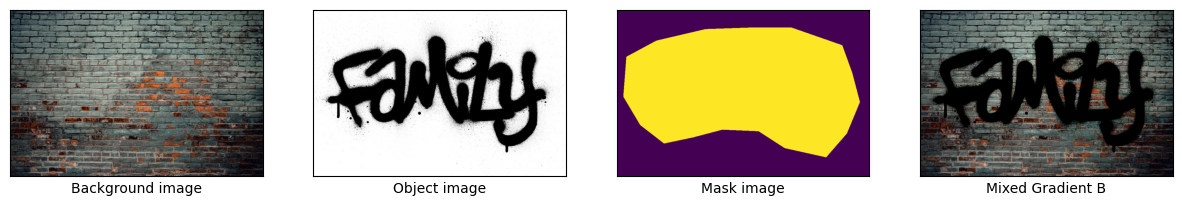

In [ ]:
show_images(
    [bg_img, obj_img, mask_img, mix_img],
    ["Background image", "Object image", "Mask image", "Mixed Gradient B"]
)

In [ ]:
#EXPERIMENT-------------------------------

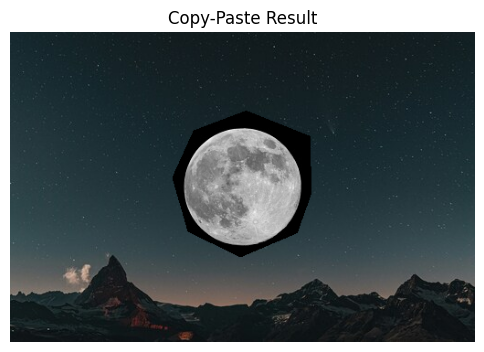

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load images
# --------------------------
bg = cv2.imread("/content/sample_data/night.jpg")
src = cv2.imread("/content/sample_data/img2.jpg")
mask = cv2.imread("/content/sample_data/mask1.jpg", 0)

bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)

# Resize to same size
h, w = bg.shape[:2]
src = cv2.resize(src, (w, h))
mask = cv2.resize(mask, (w, h))

mask_bin = (mask > 127).astype(np.uint8)

# --------------------------
# Copy-paste result (NO Poisson)
# --------------------------
blended_copy = bg.copy()
blended_copy[mask_bin == 1] = src[mask_bin == 1]

# --------------------------
# Plot result
# --------------------------
plt.figure(figsize=(6, 5))
plt.imshow(blended_copy)
plt.title("Copy-Paste Result")
plt.axis("off")
plt.show()


In [ ]:
def poisson_blend(
    img_s: np.ndarray,
    mask: np.ndarray,
    img_t: np.ndarray
) -> np.ndarray:
    """
    Returns a Poisson blended image with masked img_s over the img_t.
    :param img_s: the image containing the foreground object
    :param mask: the mask of the foreground object in object_img
    :param img_t: the background image
    """
    img_s_h, img_s_w = img_s.shape

    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)

    ys, xs = np.where(mask==1)

    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)

    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]

        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x] - img_s[n_y][n_x]

            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1

    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]

    img_t_out = img_t.copy()

    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]

    return np.clip(img_t_out, 0, 1)

In [ ]:
bg_img1 = get_image('/content/sample_data/night.jpg')
obj_img1 = get_image('/content/sample_data/img2.jpg')
mask_img1 =  get_image('/content/sample_data/mask1.jpg', mask=True)

In [ ]:
bg_imgB = get_image('/content/sample_data/wall.jpg')
obj_imgB = get_image('/content/sample_data/img4.jpg')
mask_imgB =  get_image('/content/sample_data/mask2.jpg', mask=True)

In [ ]:
blend_img = np.zeros(bg_img1.shape)
for b in np.arange(3):
    blend_img[:,:,b] = poisson_blend(obj_img1[:,:,b], mask_img1, bg_img1[:,:,b].copy())

In [ ]:
blend_imgB = np.zeros(bg_imgB.shape)#casse B
for b in np.arange(3):
    blend_imgB[:,:,b] = poisson_blend(obj_imgB[:,:,b], mask_imgB, bg_imgB[:,:,b].copy())

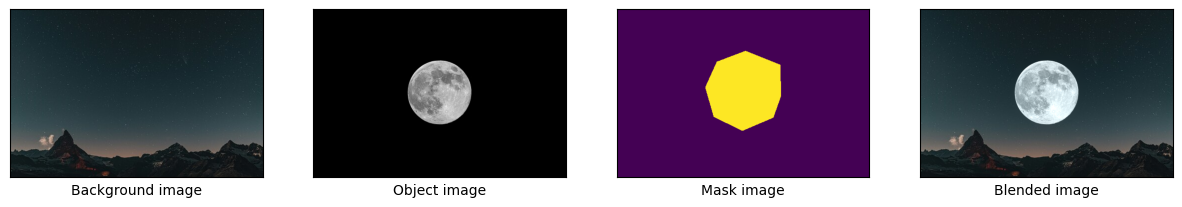

In [ ]:
show_images(
    [bg_img1, obj_img1, mask_img, blend_img],
    ["Background image", "Object image", "Mask image", "Blended image"]
)

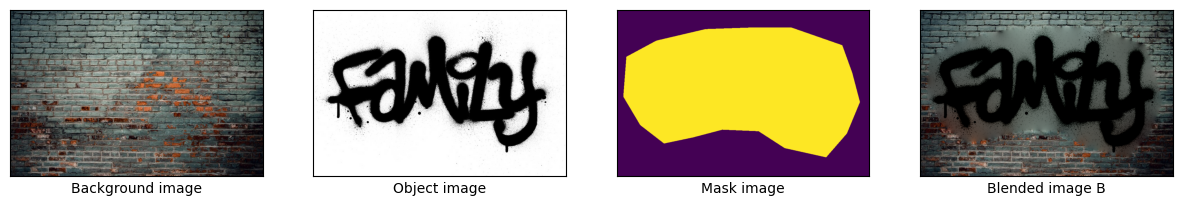

In [ ]:
show_images(
    [bg_imgB, obj_imgB, mask_imgB, blend_imgB],
    ["Background image", "Object image", "Mask image", "Blended image B"]
)

In [ ]:
mix_imgA = np.zeros(bg_img1.shape)
for b in np.arange(3):
    mix_imgA[:,:,b] = mixed_blend(obj_img1[:,:,b], mask_img1, bg_img1[:,:,b].copy())

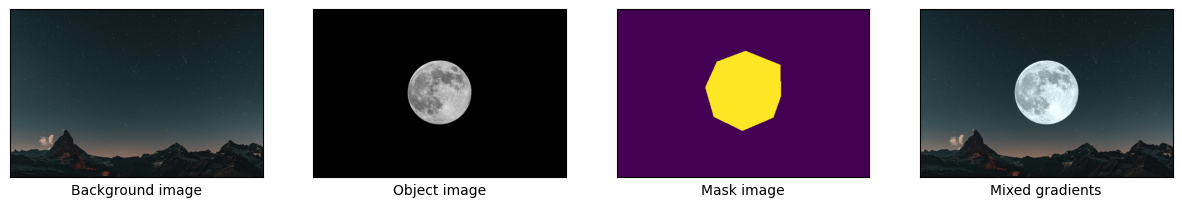

In [ ]:
show_images(
    [bg_img1, obj_img1, mask_img1, mix_imgA],
    ["Background image", "Object image", "Mask image", "Mixed gradients"]
)

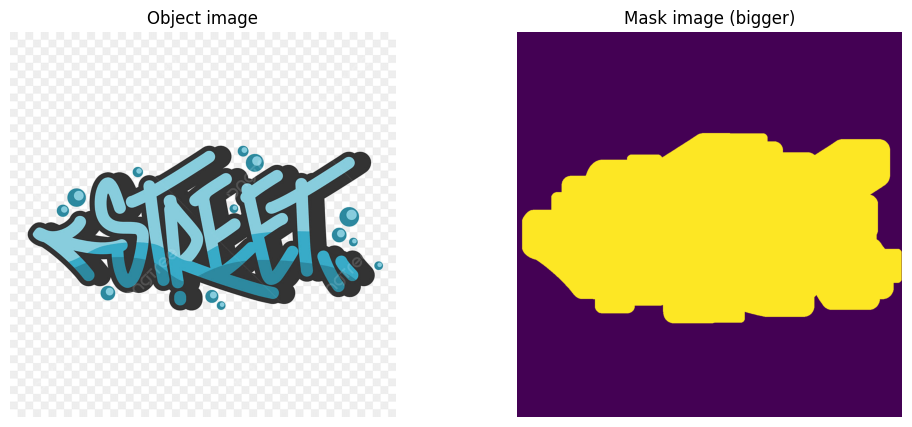

True

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Load ảnh graffiti
# ---------------------------------------------------
img = cv2.imread("/content/sample_data/st.png")    # đổi thành ảnh của bạn
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# ---------------------------------------------------
# 2. Tách nền trắng
# ---------------------------------------------------
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Clean small noise
kernel = np.ones((7, 7), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# ---------------------------------------------------
# 3. Mở rộng mask (DILATION)
# ---------------------------------------------------
# dilation_size càng lớn → mask càng to
dilation_size = 80   # tăng/giảm tùy ý
kernel = np.ones((dilation_size, dilation_size), np.uint8)
mask_big = cv2.dilate(thresh, kernel, iterations=1)

# ---------------------------------------------------
# 4. Hiển thị kết quả
# ---------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Object image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask image (bigger)")
plt.imshow(mask_big, cmap="viridis")
plt.axis("off")

plt.show()
cv2.imwrite("/content/sample_data/maskstreet.png", mask_big)



In [63]:
cv2.imwrite("/content/sample_data/maskstreet.png", mask_big)


True

In [79]:
bg_img3 = get_image('/content/sample_data/rockwall2.jpg')
obj_img3 = get_image('/content/sample_data/st.png')
mask_img3 =  get_image('/content/sample_data/maskstreet.png', mask=True)

Pixels in mask: 67827


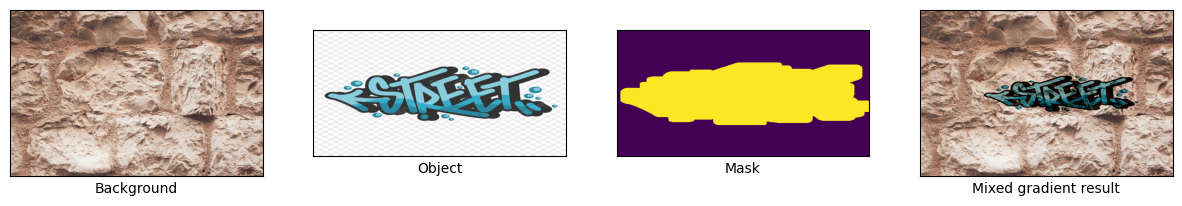

In [80]:
# ---------------------------------------------
# Resize object + mask to desired size
# ---------------------------------------------
new_h, new_w = 300, 600   # chỉnh tùy ý

# mask_img3 từ get_image() là 0/1 → convert sang uint8
mask_img3 = (mask_img3 * 255).astype('uint8')

# Resize giữ nguyên mask
mask_resized = cv2.resize(
    mask_img3,
    (new_w, new_h),
    interpolation=cv2.INTER_NEAREST  # giữ mask 0/1 không bị nhòe
)

# Convert về 0/1 cho mixed blending
mask_resized = (mask_resized > 0).astype(int)

# Resize object (float 0-1)
obj_resized  = cv2.resize(obj_img3, (new_w, new_h), interpolation=cv2.INTER_AREA)

print("Pixels in mask:", mask_resized.sum())   # debugging

# ---------------------------------------------
# Choose placement on background
# ---------------------------------------------
y, x = 150, 200   # vị trí đặt object

# Crop background region with same size
bg_crop = bg_img3[y:y+new_h, x:x+new_w].copy()

# ---------------------------------------------
# Mixed Gradient blending
# ---------------------------------------------
mix_img = np.zeros_like(bg_crop)

for b in range(3):
    mix_img[:,:,b] = mixed_blend(      # <- ONLY 1 return value!
        obj_resized[:,:,b],
        mask_resized,
        bg_crop[:,:,b]
    )

# ---------------------------------------------
# Put blended patch back onto background
# ---------------------------------------------
bg_out = bg_img3.copy()
bg_out[y:y+new_h, x:x+new_w] = mix_img

# ---------------------------------------------
# Show results
# ---------------------------------------------
show_images(
    [bg_img3, obj_resized, mask_resized, bg_out],
    ["Background", "Object", "Mask", "Mixed gradient result"]
)
